In [1]:
import torch
import onnx
import onnx_tf.backend
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\potap\FinARL\venv_10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.main import check_and_make_directories
from Envs.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

## Read data

We first read the .csv file of our training data into dataframe.

In [3]:
train = pd.read_csv(r'C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Training and Testing\Data\Daily\daily_training_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
def prep(train):
    # Sort the DataFrame by the 'date' column
    train = train.sort_values(by='date')

    # Create a mapping of unique dates to their corresponding index
    date_mapping = {date: idx for idx, date in enumerate(train['date'].unique())}

    # Map the 'date' column to the date_mapping to get the new index
    train['index'] = train['date'].map(date_mapping)

    # Set the new index for the DataFrame
    train.set_index('index', inplace=True, drop=True)
    train = train.fillna(0)
    return train

train = prep(train)

In [4]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24,160.750,162.140,159.640,161.94,69463623,AAPL,2,0.000000,166.629916,...,161.940000,161.940000,0.000000,16.79,101.000000,155.000000,194763.000000,0.532856,0.065276,0.000000
0,2021-11-24,68.000,68.060,67.230,67.28,14975544,C,2,0.000000,166.629916,...,67.280000,67.280000,0.000000,16.79,0.500000,0.000000,3.000000,0.405170,0.378201,-0.908891
0,2021-11-24,168.460,169.440,166.440,166.96,9629790,JPM,2,0.000000,166.629916,...,166.960000,166.960000,0.000000,16.79,9.000000,3.500000,76075.000000,0.427115,0.874635,-0.871683
0,2021-11-24,405.000,407.480,398.300,399.19,2186259,GS,2,0.000000,166.629916,...,399.190000,399.190000,0.000000,16.79,0.500000,0.000000,0.500000,0.376175,0.978359,-1.990723
0,2021-11-24,2909.470,2924.985,2887.460,2922.40,902007,GOOGL,2,0.000000,166.629916,...,2922.400000,2922.400000,0.000000,16.79,4.000000,1.500000,42866.000000,0.485056,0.063561,2.960632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2023-04-25,279.510,281.600,275.370,275.42,45772236,MSFT,1,3.203249,294.098138,...,281.319333,268.942833,68.125497,8.50,23.428571,27.142857,134295.714286,0.531014,0.338890,0.048389
354,2023-04-25,270.780,272.470,262.250,262.41,37852716,NVDA,1,4.918793,281.312182,...,267.028333,244.814333,68.125497,8.50,30.714286,25.857143,85588.285714,0.542114,0.325025,1.677476
354,2023-04-25,139.600,139.960,137.625,137.67,10629325,JPM,1,2.178713,144.920788,...,131.670667,135.969833,68.125497,8.50,4.571429,1.000000,77873.642857,0.508643,0.030219,-0.902556


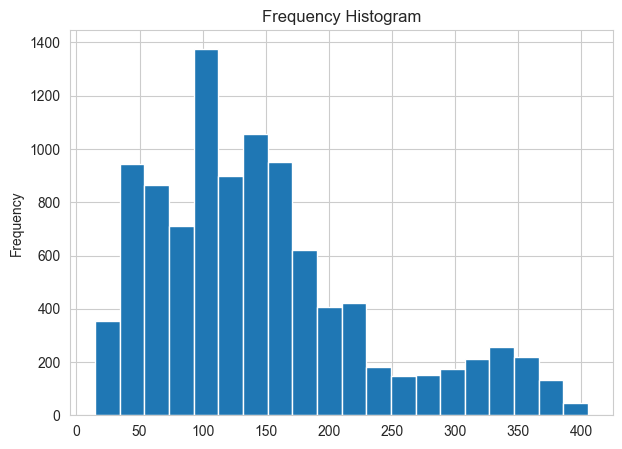

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = filtered
plt.hist(x, bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [34]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [39]:
filtered = x[~is_outlier(x.values)]

In [40]:
filtered

index
0      161.94
0       67.28
0      166.96
0      399.19
0      151.34
        ...  
354    275.42
354    262.41
354    137.67
354    207.55
354     82.92
Name: close, Length: 10123, dtype: float64

In [5]:
df_num = train.select_dtypes(include='number')
df_norm = (df_num - df_num.min()) / (df_num.max() - df_num.min())*200 + 20


train[df_norm.columns] = df_norm

In [6]:
df_norm

,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,28.153629,28.137424,28.243267,28.262428,64.916834,120.0,195.435085,28.256028,82.697630,20.000000,...,28.193665,28.140791,20.000000,136.070267,53.507109,73.966675,63.015602,172.583131,33.054634,122.638437
0,22.983049,22.937608,22.996261,22.953071,29.281144,120.0,195.435085,28.256028,82.697630,20.000000,...,22.882404,22.828066,20.000000,136.070267,20.165877,20.000000,20.000663,136.020346,95.653901,100.323846
0,28.583442,28.540896,28.629368,28.543993,25.784973,120.0,195.435085,28.256028,82.697630,20.000000,...,28.475332,28.422535,20.000000,136.070267,22.985782,21.218602,36.802020,142.304311,194.962940,101.237357
0,41.769955,41.697401,41.794293,41.569474,20.916837,120.0,195.435085,28.256028,82.697630,20.000000,...,41.505484,41.456279,20.000000,136.070267,20.165877,20.000000,20.000110,127.717562,215.712464,73.763317
0,181.387890,180.840272,183.127876,183.093068,20.076925,120.0,195.435085,28.256028,82.697630,20.000000,...,183.079832,183.069655,20.000000,136.070267,21.327014,20.522258,29.467439,158.895772,32.711696,195.326210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,34.774202,34.739995,34.814373,34.627375,49.422455,70.0,196.296315,35.261154,87.840159,124.365328,...,34.891899,34.146249,22.132966,28.197788,27.772512,29.450385,49.660721,172.055838,87.789817,123.826458
354,34.287526,34.235379,34.069424,33.897661,44.243018,70.0,196.757558,34.558491,87.209667,133.181107,...,34.090048,32.792054,22.132966,28.197788,30.189573,29.002736,38.903137,175.234321,85.016297,163.822887
354,26.974569,26.911532,26.993263,26.901155,26.438678,70.0,196.020857,27.062984,81.436076,126.644191,...,26.495288,26.683234,22.132966,28.197788,21.516588,20.348172,37.199271,165.649784,26.041793,100.479398


In [7]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24,28.153629,28.137424,28.243267,28.262428,64.916834,AAPL,120.0,195.435085,28.256028,...,28.193665,28.140791,20.000000,136.070267,53.507109,73.966675,63.015602,172.583131,33.054634,122.638437
0,2021-11-24,22.983049,22.937608,22.996261,22.953071,29.281144,C,120.0,195.435085,28.256028,...,22.882404,22.828066,20.000000,136.070267,20.165877,20.000000,20.000663,136.020346,95.653901,100.323846
0,2021-11-24,28.583442,28.540896,28.629368,28.543993,25.784973,JPM,120.0,195.435085,28.256028,...,28.475332,28.422535,20.000000,136.070267,22.985782,21.218602,36.802020,142.304311,194.962940,101.237357
0,2021-11-24,41.769955,41.697401,41.794293,41.569474,20.916837,GS,120.0,195.435085,28.256028,...,41.505484,41.456279,20.000000,136.070267,20.165877,20.000000,20.000110,127.717562,215.712464,73.763317
0,2021-11-24,181.387890,180.840272,183.127876,183.093068,20.076925,GOOGL,120.0,195.435085,28.256028,...,183.079832,183.069655,20.000000,136.070267,21.327014,20.522258,29.467439,158.895772,32.711696,195.326210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2023-04-25,34.774202,34.739995,34.814373,34.627375,49.422455,MSFT,70.0,196.296315,35.261154,...,34.891899,34.146249,22.132966,28.197788,27.772512,29.450385,49.660721,172.055838,87.789817,123.826458
354,2023-04-25,34.287526,34.235379,34.069424,33.897661,44.243018,NVDA,70.0,196.757558,34.558491,...,34.090048,32.792054,22.132966,28.197788,30.189573,29.002736,38.903137,175.234321,85.016297,163.822887
354,2023-04-25,26.974569,26.911532,26.993263,26.901155,26.438678,JPM,70.0,196.020857,27.062984,...,26.495288,26.683234,22.132966,28.197788,21.516588,20.348172,37.199271,165.649784,26.041793,100.479398


Goal for generated data: one more column for sentiment for each day --> Merge on "tic" and "date"

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [8]:
INDICATORS.append('vix')

INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'vix']

In [9]:
SENTIMENT = ['random']
#'stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 

In [10]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 4 * stock_dimension + len(INDICATORS) * stock_dimension + len(SENTIMENT) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 421


In [11]:
seed = 0
hourly = False

In [12]:
buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "sentiment_list": SENTIMENT,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "seed": seed,
    "hourly": hourly
}


e_train_gym = StockTradingEnv(df = train,risk_indicator_col='vix', **env_kwargs)

## Environment for training

In [13]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Get onnx model

In [14]:
saved_model_path = r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Training and Testing\Evaluation\model\daily\noSentiment\a2c\seed0.zip"

In [15]:
agent = DRLAgent(env = env_train)

In [16]:
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [17]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=500)

-------------------------------------
| time/                 |           |
|    fps                | 132       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.4     |
|    explained_variance | -0.0483   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 86.3      |
|    reward             | 6.0244045 |
|    std                | 0.996     |
|    value_loss         | 5.97      |
-------------------------------------


In [18]:
loaded_agent = trained_a2c.load(saved_model_path)

In [19]:
# Make sure your model is in evaluation mode
loaded_agent.policy.eval()

# generate dummy input
observation_size = loaded_agent.observation_space.shape[0]
dummy_input = torch.randn(1, observation_size)

# Export the model to ONNX format
torch.onnx.export(loaded_agent.policy, dummy_input, "policy.onnx")


C:\Users\potap\FinARL\venv_10\lib\site-packages\stable_baselines3\common\distributions.py:87: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if deterministic:


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


In [20]:
import onnx

from onnx_tf.backend import prepare

onnx_model = onnx.load(r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\policy.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph(r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\HIERoutput.pb")  # export the model

INFO:tensorflow:Assets written to: C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\HIERoutput.pb\assets


INFO:tensorflow:Assets written to: C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\HIERoutput.pb\assets


In [21]:
import tensorflow as tf
model_filename = r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\HIERoutput.pb"
# Load the TensorFlow model
model_loaded = tf.saved_model.load(model_filename)
model_loaded = model_loaded.signatures['serving_default']
model_loaded

<ConcreteFunction signature_wrapper(*, obs) at 0x11A5D08DA80>

#  Sensitivity test

In [22]:
# generate dummy input
#observation_size = model_loaded.observation_space.shape[0]
dummy_input = torch.randn(1, 421)

In [23]:
xs = tf.convert_to_tensor(dummy_input)

In [24]:
with tf.GradientTape() as tape:
    tape.watch(xs)
    pred = model_loaded(xs)
    grads = tape.gradient(pred, xs)

In [25]:
assert (grads is not None) # sanity check
grads = grads.numpy()
abs_grads_sum = np.sum(np.abs(grads), axis=0)


In [26]:
abs_grads_sum

array([6.141937  , 2.0792143 , 1.1400537 , 2.5549965 , 0.25538453,
       0.1457287 , 0.91045415, 0.96804583, 1.9791678 , 0.5729369 ,
       1.5138545 , 4.8658857 , 2.0542839 , 8.757634  , 2.349398  ,
       0.69924116, 0.51150405, 0.30408013, 2.6819537 , 1.6688392 ,
       0.86045796, 2.3970149 , 4.1402144 , 2.1240876 , 3.4856312 ,
       1.8171442 , 0.95222837, 5.228218  , 2.5927901 , 3.7669134 ,
       4.3272204 , 2.3591924 , 3.966771  , 2.1997342 , 0.16204202,
       2.7498965 , 2.9850717 , 5.7253227 , 1.7466173 , 4.11631   ,
       3.633401  , 0.22664887, 4.170761  , 2.1862285 , 1.8478186 ,
       2.5734751 , 1.0064908 , 1.0574986 , 2.846866  , 0.23595265,
       0.42381045, 2.6337516 , 1.8567915 , 0.72375774, 1.3361348 ,
       1.9963938 , 5.43626   , 1.2364389 , 5.980402  , 5.040382  ,
       0.66498214, 1.7261225 , 2.0128493 , 0.21035725, 1.1941941 ,
       3.3602214 , 0.70596945, 1.2577521 , 2.3316288 , 2.774733  ,
       0.28998908, 0.36586928, 3.451414  , 3.371114  , 2.72316

# Unsere Data

In [27]:
num_stock_shares = 30*[0]

In [28]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24,28.153629,28.137424,28.243267,28.262428,64.916834,AAPL,120.0,195.435085,28.256028,...,28.193665,28.140791,20.000000,136.070267,53.507109,73.966675,63.015602,172.583131,33.054634,122.638437
0,2021-11-24,22.983049,22.937608,22.996261,22.953071,29.281144,C,120.0,195.435085,28.256028,...,22.882404,22.828066,20.000000,136.070267,20.165877,20.000000,20.000663,136.020346,95.653901,100.323846
0,2021-11-24,28.583442,28.540896,28.629368,28.543993,25.784973,JPM,120.0,195.435085,28.256028,...,28.475332,28.422535,20.000000,136.070267,22.985782,21.218602,36.802020,142.304311,194.962940,101.237357
0,2021-11-24,41.769955,41.697401,41.794293,41.569474,20.916837,GS,120.0,195.435085,28.256028,...,41.505484,41.456279,20.000000,136.070267,20.165877,20.000000,20.000110,127.717562,215.712464,73.763317
0,2021-11-24,181.387890,180.840272,183.127876,183.093068,20.076925,GOOGL,120.0,195.435085,28.256028,...,183.079832,183.069655,20.000000,136.070267,21.327014,20.522258,29.467439,158.895772,32.711696,195.326210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2023-04-25,34.774202,34.739995,34.814373,34.627375,49.422455,MSFT,70.0,196.296315,35.261154,...,34.891899,34.146249,22.132966,28.197788,27.772512,29.450385,49.660721,172.055838,87.789817,123.826458
354,2023-04-25,34.287526,34.235379,34.069424,33.897661,44.243018,NVDA,70.0,196.757558,34.558491,...,34.090048,32.792054,22.132966,28.197788,30.189573,29.002736,38.903137,175.234321,85.016297,163.822887
354,2023-04-25,26.974569,26.911532,26.993263,26.901155,26.438678,JPM,70.0,196.020857,27.062984,...,26.495288,26.683234,22.132966,28.197788,21.516588,20.348172,37.199271,165.649784,26.041793,100.479398


In [49]:
all_days_grads = []
for day in range(len((train.date.unique()))): # len((train.date.unique()))
   data = train.loc[day, :]
   
   state = (
    [50]
    + data.close.values.tolist()
    + num_stock_shares
    + sum(
        (
            data[tech].values.tolist()
            for tech in INDICATORS
        ),
        [],
    )
    + sum(
    (
        data[sent].values.tolist()
        for sent in SENTIMENT
    ),
    [],
)
    + data.change.values.tolist()
    + data.volume.values.tolist())
   
   #print(state)
   xs = tf.convert_to_tensor([state])
   with tf.GradientTape() as tape:
        tape.watch(xs)
        pred = model_loaded(xs)
        grads = tape.gradient(pred, xs)
   grads = grads.numpy()
   abs_grads_sum = np.sum(np.abs(grads), axis=0)
   all_days_grads.append(abs_grads_sum)

In [50]:
all_days_grads

[array([4.9641253e-03, 7.6399650e-04, 1.1945408e-02, 1.7248648e-03,
        6.7071673e-03, 1.3017851e-03, 8.7275393e-03, 7.9740863e-04,
        2.3168488e-03, 9.3358476e-03, 4.3594078e-03, 5.3903656e-03,
        2.4399180e-03, 7.9396821e-04, 4.6704095e-03, 1.8796717e-03,
        7.9845134e-03, 4.7742100e-03, 3.3215343e-03, 7.1599847e-03,
        8.1183398e-03, 8.6725485e-03, 1.0208614e-02, 3.9037224e-03,
        2.0098481e-03, 5.1503237e-03, 5.5021625e-03, 8.2849870e-03,
        1.5871737e-03, 4.3453436e-04, 7.5882464e-04, 4.6923468e-03,
        4.8822821e-03, 6.0819825e-03, 4.4720089e-03, 1.0709695e-03,
        9.6291408e-04, 3.1154775e-03, 3.4043079e-03, 1.9494155e-03,
        7.2159339e-03, 3.4571528e-03, 1.0037667e-03, 3.0093230e-03,
        1.7491019e-03, 3.0972944e-03, 6.8598618e-03, 2.9848819e-03,
        8.1514474e-03, 1.0814022e-02, 2.3782440e-03, 3.7181913e-04,
        2.0495132e-03, 5.2178218e-03, 3.9293999e-03, 1.2408731e-03,
        1.7959736e-03, 7.6526697e-03, 3.7428527e

In [51]:
import matplotlib
matplotlib.use('TkAgg')  # or another appropriate backend like 'Qt5Agg'
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(all_days_grads, cmap="YlGnBu", cbar=True)

# Display the plot
plt.title('Heatmap of all_days_grads')
plt.xlabel('Index within each sublist')
plt.ylabel('List index')
plt.show()

In [48]:
len(state)

421

In [53]:
sums = [sum(day[i] for day in all_days_grads) for i in range(421)]
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.bar(range(421), sums)
plt.title('Sum of values at each index across all days')
plt.xlabel('Index')
plt.ylabel('Sum')
plt.show()
